# 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받아 null값을 제거한 데이터를 사용합니다

df = pd.read_csv('C:\Jupyter_Project\Hanyang_Securities_F.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6300,7100,6300,7000,1619.266357,56800
1,2000-01-05,6700,7100,6610,6700,1549.868774,52100
2,2000-01-06,7000,7000,6250,6300,1457.339844,64900
3,2000-01-07,6350,6600,6300,6370,1473.532349,61800
4,2000-01-10,6610,6700,6300,6500,1503.603882,56100


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5181,2021-02-01,9200,9480,9100,9380,9380.0,81355
5182,2021-02-02,9460,9810,9460,9700,9700.0,105755
5183,2021-02-03,9850,10200,9800,9990,9990.0,170966
5184,2021-02-04,10100,10200,9940,10150,10150.0,133504
5185,2021-02-05,10200,10800,10150,10650,10650.0,247224


In [4]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0       0.231324
1       0.231324
2       0.231324
3       0.231324
4       0.231324
          ...   
5181    1.000000
5182    1.000000
5183    1.000000
5184    1.000000
5185    1.000000
Length: 5186, dtype: float64

In [5]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [6]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [7]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,1457.339721,1642.398734,1457.339721,1619.266357,56800
1,1549.868774,1642.398253,1529.049641,1549.868774,52100
2,1619.266493,1619.266493,1445.773655,1457.339844,64900
3,1468.905874,1526.736814,1457.339686,1473.532349,61800
4,1529.049486,1549.868617,1457.339147,1503.603882,56100
...,...,...,...,...,...
5181,9200.000000,9480.000000,9100.000000,9380.000000,81355
5182,9460.000000,9810.000000,9460.000000,9700.000000,105755
5183,9850.000000,10200.000000,9800.000000,9990.000000,170966
5184,10100.000000,10200.000000,9940.000000,10150.000000,133504


In [9]:
# MinMaxScaler 클래스를 사용하여 데이터를 스케일링 합니다.
# MinMaxScaler는 데이터의 최대값이 1, 최소값이 0이 되도록 변환합니다

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

# 정규화가 완료된 데이터들은 pandas dataframe으로 변환합니다
# pandas는 시계열 자료에 대한 다양한 기능을 제공하여 LSTM에서 사용하는 window를 만들때 유용합니다

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.069093  0.078420  0.072692  0.082280  0.020301
1     0.076891  0.078420  0.078924  0.076473  0.018620
2     0.082740  0.076587  0.071686  0.068730  0.023197
3     0.070068  0.069256  0.072692  0.070085  0.022088
4     0.075136  0.071089  0.072692  0.072601  0.020050
...        ...       ...       ...       ...       ...
5181  0.721622  0.699387  0.736878  0.731697  0.029080
5182  0.743534  0.725532  0.768164  0.758474  0.037804
5183  0.776402  0.756432  0.797711  0.782742  0.061119
5184  0.797472  0.756432  0.809878  0.796130  0.047725
5185  0.805899  0.803969  0.828128  0.837970  0.088383

[5186 rows x 5 columns]


In [10]:
# window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다
# window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값의 예측하게 됩니다
# 테스트 기간은 21일, 따라서 5299-21 : train / 21 : test

window_size = 20
TEST_SIZE = 1037

In [11]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [12]:
test.describe()

,Open,High,Low,Close,Volume
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,0.555879,0.526694,0.567086,0.551764,0.012608
std,0.079533,0.076859,0.080378,0.079329,0.036624
min,0.319620,0.315917,0.326686,0.314971,0.000169
25%,0.502964,0.475662,0.513952,0.498957,0.002769
50%,0.539574,0.509858,0.550341,0.535049,0.005645
75%,0.568782,0.538644,0.580720,0.565572,0.012352
max,0.831182,0.803969,0.828128,0.837970,1.000000


In [13]:
# Train과 Test를 분할합니다

from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [19]:
x_train.shape, y_train.shape

((4148, 4), (4148,))

In [20]:
x_test.shape, y_test.shape

((1038, 4), (1038,))

In [21]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
 
x_test -= mean
x_test /= std

In [33]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras import models
from keras import layers
from keras import backend as K


def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    # 마지막 레이어는 주택가격인 Y값 1개만 예측하면 되기 때문에 뉴런 수는 1개
    model = Sequential()
    model.add(layers.Dense(20, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(Dense(1))
    
    def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

    def soft_acc(y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    
    # 손실함수는 mse(예측값과 실제값 사이 거리의 제곱) 이용
    # 모니터링은 mse(예측값과 실제값 사이 거리의 절댓값) 이용
    model.compile(optimizer='adam', loss=RMSE, metrics=[soft_acc])
    return model

In [ ]:
# k-겹 교차 검증 실시
# 현재 10겹이므로 한번 실행마다 50번 반복하고 결국 500번을 훈련하게 된다
# #0의 10개의 mae평균, #1의 10개의 mae평균,,,50번대의 10개의 mae평균,,,이렇게 500개의 mae를 구한다


k = 10

# len(train_data), 404
num_val_samples = len(x_train) // k # 101
num_epochs = 50
all_scores = []
all_soft_acc_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
 
    # 훈련 데이터 준비: 다른 분할 전체
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
 
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # model.fit()함수로 회귀 모델을 학습시킨다
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=32, verbose=1)
    soft_acc_history = history.history['val_soft_acc']
    all_soft_acc_histories.append(soft_acc_history)
 
average_soft_acc_history = [np.mean([x[i] for x in all_soft_acc_histories]) for i in range(num_epochs)]

처리중인 폴드 # 0
Epoch 1/50
117/117 [==============================] - 1s 4ms/step - loss: 5159.5683 - soft_acc: 0.0000e+00 - val_loss: 1053.5875 - val_soft_acc: 0.0000e+00
Epoch 2/50
117/117 [==============================] - 0s 2ms/step - loss: 5127.9702 - soft_acc: 0.0000e+00 - val_loss: 1050.3785 - val_soft_acc: 0.0000e+00
Epoch 3/50
117/117 [==============================] - 0s 2ms/step - loss: 5098.4626 - soft_acc: 0.0000e+00 - val_loss: 1045.7194 - val_soft_acc: 0.0000e+00
Epoch 4/50
117/117 [==============================] - 0s 2ms/step - loss: 5160.2328 - soft_acc: 0.0000e+00 - val_loss: 1039.8851 - val_soft_acc: 0.0000e+00
Epoch 5/50
117/117 [==============================] - 0s 2ms/step - loss: 5079.1659 - soft_acc: 0.0000e+00 - val_loss: 1033.5695 - val_soft_acc: 0.0000e+00
Epoch 6/50
117/117 [==============================] - 0s 2ms/step - loss: 5095.2506 - soft_acc: 0.0000e+00 - val_loss: 1026.7897 - val_soft_acc: 0.0000e+00
Epoch 7/50
117/117 [==============================] 

117/117 [==============================] - 0s 2ms/step - loss: 5130.6816 - soft_acc: 0.0000e+00 - val_loss: 1317.3826 - val_soft_acc: 0.0000e+00
Epoch 4/50
117/117 [==============================] - 0s 3ms/step - loss: 5035.5802 - soft_acc: 0.0000e+00 - val_loss: 1316.2913 - val_soft_acc: 0.0000e+00
Epoch 5/50
117/117 [==============================] - 0s 2ms/step - loss: 5062.2036 - soft_acc: 0.0000e+00 - val_loss: 1314.4056 - val_soft_acc: 0.0000e+00
Epoch 6/50
117/117 [==============================] - 0s 3ms/step - loss: 5103.6186 - soft_acc: 0.0000e+00 - val_loss: 1312.1779 - val_soft_acc: 0.0000e+00
Epoch 7/50
117/117 [==============================] - 0s 3ms/step - loss: 5144.3862 - soft_acc: 0.0000e+00 - val_loss: 1310.5454 - val_soft_acc: 0.0000e+00
Epoch 8/50
117/117 [==============================] - 0s 2ms/step - loss: 5103.5429 - soft_acc: 0.0000e+00 - val_loss: 1309.4424 - val_soft_acc: 0.0000e+00
Epoch 9/50
117/117 [==============================] - 0s 2ms/step - loss: 5

117/117 [==============================] - 0s 3ms/step - loss: 5121.9599 - soft_acc: 0.0000e+00 - val_loss: 1051.9871 - val_soft_acc: 0.0000e+00
Epoch 6/50
117/117 [==============================] - 0s 3ms/step - loss: 5057.7739 - soft_acc: 0.0000e+00 - val_loss: 1047.6569 - val_soft_acc: 0.0000e+00
Epoch 7/50
117/117 [==============================] - 0s 2ms/step - loss: 5053.8223 - soft_acc: 0.0000e+00 - val_loss: 1043.0712 - val_soft_acc: 0.0000e+00
Epoch 8/50
117/117 [==============================] - 0s 2ms/step - loss: 5119.0145 - soft_acc: 0.0000e+00 - val_loss: 1038.0116 - val_soft_acc: 0.0000e+00
Epoch 9/50
117/117 [==============================] - 0s 3ms/step - loss: 5107.0271 - soft_acc: 0.0000e+00 - val_loss: 1032.0452 - val_soft_acc: 0.0000e+00
Epoch 10/50
117/117 [==============================] - 0s 3ms/step - loss: 5024.1485 - soft_acc: 0.0000e+00 - val_loss: 1024.8276 - val_soft_acc: 0.0000e+00
Epoch 11/50
117/117 [==============================] - 0s 3ms/step - loss:

117/117 [==============================] - 0s 3ms/step - loss: 4999.2067 - soft_acc: 0.0000e+00 - val_loss: 3278.5339 - val_soft_acc: 0.0000e+00
Epoch 8/50
117/117 [==============================] - 0s 3ms/step - loss: 5004.6367 - soft_acc: 0.0000e+00 - val_loss: 3273.7925 - val_soft_acc: 0.0000e+00
Epoch 9/50
117/117 [==============================] - 0s 2ms/step - loss: 5005.5564 - soft_acc: 0.0000e+00 - val_loss: 3268.5767 - val_soft_acc: 0.0000e+00
Epoch 10/50
117/117 [==============================] - 0s 2ms/step - loss: 4936.1991 - soft_acc: 0.0000e+00 - val_loss: 3262.8193 - val_soft_acc: 0.0000e+00
Epoch 11/50
117/117 [==============================] - 0s 2ms/step - loss: 4960.0508 - soft_acc: 0.0000e+00 - val_loss: 3256.4934 - val_soft_acc: 0.0000e+00
Epoch 12/50
117/117 [==============================] - 0s 2ms/step - loss: 4941.8826 - soft_acc: 0.0000e+00 - val_loss: 3249.6411 - val_soft_acc: 0.0000e+00
Epoch 13/50
117/117 [==============================] - 0s 3ms/step - los

117/117 [==============================] - 0s 2ms/step - loss: 4255.1088 - soft_acc: 0.0000e+00 - val_loss: 7927.8638 - val_soft_acc: 0.0000e+00
Epoch 10/50
117/117 [==============================] - 0s 2ms/step - loss: 4241.9454 - soft_acc: 0.0000e+00 - val_loss: 7896.3540 - val_soft_acc: 0.0000e+00
Epoch 11/50
117/117 [==============================] - 0s 2ms/step - loss: 4279.0356 - soft_acc: 0.0000e+00 - val_loss: 7862.1362 - val_soft_acc: 0.0000e+00
Epoch 12/50
117/117 [==============================] - 0s 1ms/step - loss: 4251.1215 - soft_acc: 0.0000e+00 - val_loss: 7825.4199 - val_soft_acc: 0.0000e+00
Epoch 13/50
117/117 [==============================] - 0s 2ms/step - loss: 4242.7200 - soft_acc: 0.0000e+00 - val_loss: 7785.8672 - val_soft_acc: 0.0000e+00
Epoch 14/50
117/117 [==============================] - 0s 2ms/step - loss: 4186.4432 - soft_acc: 0.0000e+00 - val_loss: 7744.4336 - val_soft_acc: 0.0000e+00
Epoch 15/50
117/117 [==============================] - 0s 2ms/step - l

117/117 [==============================] - 0s 2ms/step - loss: 4659.0084 - soft_acc: 0.0000e+00 - val_loss: 5793.1279 - val_soft_acc: 0.0000e+00
Epoch 12/50
117/117 [==============================] - 0s 2ms/step - loss: 4635.6771 - soft_acc: 0.0000e+00 - val_loss: 5771.2759 - val_soft_acc: 0.0000e+00
Epoch 13/50
117/117 [==============================] - 0s 3ms/step - loss: 4598.6133 - soft_acc: 0.0000e+00 - val_loss: 5747.7529 - val_soft_acc: 0.0000e+00
Epoch 14/50
117/117 [==============================] - 0s 3ms/step - loss: 4618.1242 - soft_acc: 0.0000e+00 - val_loss: 5722.7417 - val_soft_acc: 0.0000e+00
Epoch 15/50
117/117 [==============================] - 0s 2ms/step - loss: 4648.0419 - soft_acc: 0.0000e+00 - val_loss: 5696.5518 - val_soft_acc: 0.0000e+00
Epoch 16/50
117/117 [==============================] - 0s 2ms/step - loss: 4526.5264 - soft_acc: 0.0000e+00 - val_loss: 5668.5425 - val_soft_acc: 0.0000e+00
Epoch 17/50
117/117 [==============================] - 0s 2ms/step - l

117/117 [==============================] - 0s 3ms/step - loss: 4643.7794 - soft_acc: 0.0000e+00 - val_loss: 5301.3945 - val_soft_acc: 0.0000e+00
Epoch 14/50
117/117 [==============================] - 0s 2ms/step - loss: 4585.5713 - soft_acc: 0.0000e+00 - val_loss: 5272.9116 - val_soft_acc: 0.0000e+00
Epoch 15/50
117/117 [==============================] - 0s 2ms/step - loss: 4588.3818 - soft_acc: 0.0000e+00 - val_loss: 5242.8818 - val_soft_acc: 0.0000e+00
Epoch 16/50
117/117 [==============================] - 0s 2ms/step - loss: 4440.1427 - soft_acc: 0.0000e+00 - val_loss: 5211.3545 - val_soft_acc: 0.0000e+00
Epoch 17/50
117/117 [==============================] - 0s 2ms/step - loss: 4500.1482 - soft_acc: 0.0000e+00 - val_loss: 5178.2007 - val_soft_acc: 0.0000e+00
Epoch 18/50
117/117 [==============================] - 0s 2ms/step - loss: 4466.1350 - soft_acc: 0.0000e+00 - val_loss: 5143.6821 - val_soft_acc: 0.0000e+00
Epoch 19/50
117/117 [==============================] - 0s 3ms/step - l

# Visualize
> 그래프를 보면 앞서 진행했던 LSTM(vr.1)모델 보다 실제 차트와 근사하게 예측 모형이 생성되었음을 알 수 있습니다. 훈련의 횟수가 훨씬 많기 때문이고 중간에 멈추게 하는 요소도 없는 등 훈련 방식에 있어서 차이가 있기 때문입니다. model loss 그래프를 살펴보면 epoch가 증가할수록 model loss가 급격히 줄어드는 경향은 비슷하나 절대적인 loss값 또한 LSTM(vr.2)모델이 우위에 있음을 확인할 수 있습니다 

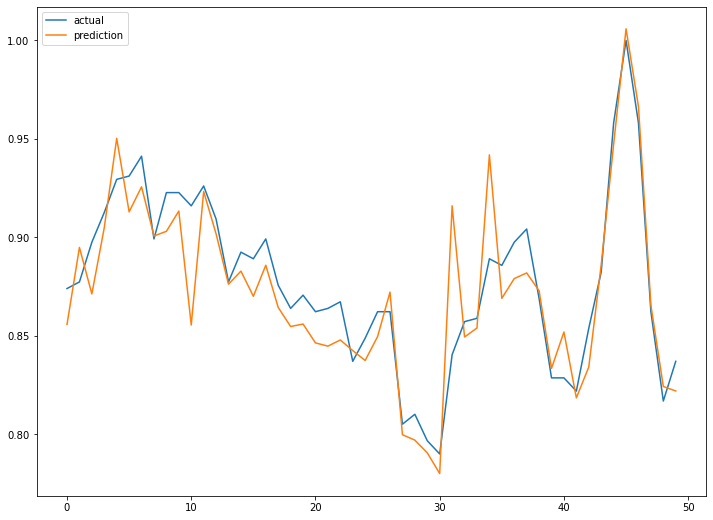

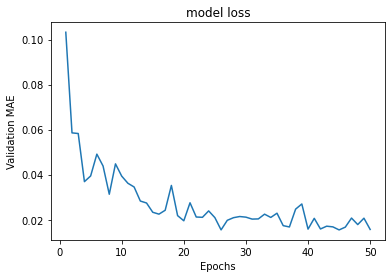

In [83]:
import matplotlib.pyplot as plt

pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('model loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()